## Good Enough Choices
A project that will give us a few healthy eating options when we are on the road.


In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import pandas as pd
import html5lib
import requests
import string
from bs4 import BeautifulSoup
import sqlite3 as lite
from pandas.io import sql

import numpy as np
from pandas import DataFrame, Series, read_csv
import matplotlib.pyplot as plt
import matplotlib 
import re
import itertools

# Enable inline plotting
%matplotlib inline

# Extend the Limit of rows
pd.options.display.max_rows = 150

In [2]:
url= 'http://www.acaloriecounter.com/fast-food.php'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html5lib')

In [3]:
# returns titles in a list named TABLE_TITLE.
TABLE_TITLE = []
for item in soup.find_all('h2'):
    TABLE_TITLE.append(item.text.rstrip('\n'))

# |REMOVING LAST TWO ROWS FROM THE TABLE TITLE LIST. #RETURNS COMPELTE LIST OF TITLE 
# |TABLES ON SITE.
TABLE_TITLE = TABLE_TITLE[:10]

# printing the results of the categories.
counter = 0
for title in TABLE_TITLE:
    counter += 1
    print ('Table #:| Category: ')
    print (counter,' :     ', title)
    print ('-'*70)
    print ('\n')

Table #:| Category: 
1  :      French Fries (Large) Compared
----------------------------------------------------------------------


Table #:| Category: 
2  :      Hamburgers Compared
----------------------------------------------------------------------


Table #:| Category: 
3  :      Sandwiches/Hamburgers Compared
----------------------------------------------------------------------


Table #:| Category: 
4  :      Chicken (Individual Pieces) Compared
----------------------------------------------------------------------


Table #:| Category: 
5  :      Chicken Sandwiches Compared
----------------------------------------------------------------------


Table #:| Category: 
6  :      Onion Rings Compared
----------------------------------------------------------------------


Table #:| Category: 
7  :      Breakfast Sandwiches/Biscuits/Croissants/Wraps Compared
----------------------------------------------------------------------


Table #:| Category: 
8  :      Mozzarella Sticks 

In [4]:
TABLE_CATEGORIES = ['Restaurants',
             'Type',
             'Serving_Size',
             'Calories',
             'Total_Fat',
             'Saturated_Fat',
             'Trans_Fat',
             'Carbs',
             'Sodium'
            ]

In [5]:
#Soup object returns all rows from all tables and saves the to a list.
TABLES_DATA = []
for tables in soup.find_all("table"):
    table = []
    for rows in tables.find('tbody'):
        for items in rows:
            for text in items:
                if text == ' ':
                    pass
                elif text == '\n':
                    pass
                elif text == '\t':
                    pass
                else:
                    table.append(text.replace('*', '').replace('\n', ''))
    TABLES_DATA.append(table)

    counter = 0

#displays the TABLE TITLE and corresponding first ROWS of the Table.
for table in TABLES_DATA:
    print ('\n')
    print ('Table : ', TABLE_TITLE[counter])
    print ('-'*70)
    counter += 1
    for row in table[:9]:
        print (row)
    



Table :  French Fries (Large) Compared
----------------------------------------------------------------------
McDonald's
Regular
170
570
30
6
8
70
330


Table :  Hamburgers Compared
----------------------------------------------------------------------
McDonald's
Regular
100
250
9
3.5
0.5
31
520


Table :  Sandwiches/Hamburgers Compared
----------------------------------------------------------------------
McDonald's
Quarter Pounder
169
410
19
7
1
37
730


Table :  Chicken (Individual Pieces) Compared
----------------------------------------------------------------------
McDonald's
Chicken McNuggets (6pc)
96
250
15
3
1.5
15
670


Table :  Chicken Sandwiches Compared
----------------------------------------------------------------------
McDonald's
McChicken
147
360
16
3.5
1
40
790


Table :  Onion Rings Compared
----------------------------------------------------------------------
Burger King (King Size)
150
500
25
5
4.5
62
720
A&W


Table :  Breakfast Sandwiches/Biscuits/Croissants/

In [6]:
Table_Names = ['Fries',
               'Hamburgers',
               'Sandwiches_Hamburger',
               'Chicken_Pieces',
               'Chicken_Sandwiches',
               'Onion_Rings',
               'Bkfst_Sandwiches',
               'Mozzarella_Sticks',
               'BreadSticks_CheesyBread',
               'Pizza_Large14'
              ]


In [7]:
def parse_table(table):
    results = []
    counter = 0
    table_row = []
    for row in table:
        try:
            table_row.append(float(row))
        except Exception as e:
            table_row.append(row)
        counter += 1
        if counter % 9 == 0:
            results.append(table_row)
            table_row = []
    return results

In [8]:
def easy_dataframe(table_list, table_catg):
    df_object = pd.DataFrame(table_list, columns = table_catg)
    return df_object.replace('Unknown', 0)

In [9]:
counter = 0
for item in Table_Names:
    exec('{} = easy_dataframe({},{})'.format(item.strip(),
                                             parse_table(TABLES_DATA[counter]),
                                             TABLE_CATEGORIES))
    counter += 1

In [10]:
#During this process, there is a discrepancy that must be handled so that all the tables are formated correctly
# Onion Rings does not have a Type column, and there it has not formated properly.
# Some additional parsing and custom function to solve this for ONION Rings at this point.
def parse_onions(table):
    results = []
    counter = 0
    table_row = []
    for row in table:
        try:
            table_row.append(float(row))
        except Exception as e:
            table_row.append(row)
        counter += 1
        if counter % 8 == 0:
            results.append(table_row)
            table_row = []
    return results

ONION_CATEGORIES = ['Restaurants',
             'Serving_Size',
             'Calories',
             'Total_Fat',
             'Saturated_Fat',
             'Trans_Fat',
             'Carbs',
             'Sodium'
            ]
Onion_Rings = easy_dataframe(parse_onions(TABLES_DATA[5]), ONION_CATEGORIES)

## Calorie Calcuation
Converting grams into calories for fat and and carb
    1gram fat = 9 calories
    1gram carb = 4 calories

Then finding the remaining calories which should be protien, then converting it into grams.
    1gram protien = 4 calories

In [11]:
def extra_columns(table):
    #Calorie conversion
    CarbsCal = table['Carbs'] * 4
    FatCal = table['Total_Fat'] * 9
    
    #finding protein
    TotalKnownCal = CarbsCal + FatCal
    ProteinCal = table['Calories'] - TotalKnownCal
    Protein = ProteinCal / 4
    
    #adding ratio in percentage
    CarbsRatio = (CarbsCal / table['Calories'])* 100
    FatRatio = (FatCal / table['Calories'])* 100
    ProteinRatio = (ProteinCal / table['Calories']) * 100
    
    #inserting rows
    table.insert(4,'Protein', Protein)
    table['Carb_Ratio'] = CarbsRatio
    table['Fat_Ratio'] = FatRatio
    table['Protein_Ratio'] = ProteinRatio 
    return table

## Adding Extra Tables
Here we are adding extra columns for the values we did the calculations above

In [12]:
Fries = extra_columns(Fries)
Hamburgers = extra_columns(Hamburgers)
Sandwiches_Hamburger = extra_columns(Sandwiches_Hamburger)
Chicken_Pieces = extra_columns(Chicken_Pieces)
Chicken_Sandwiches = extra_columns(Chicken_Sandwiches)
Onion_Rings = extra_columns(Onion_Rings)
Bkfst_Sandwiches = extra_columns(Bkfst_Sandwiches)
Mozzarella_Sticks = extra_columns(Mozzarella_Sticks)
BreadSticks_CheesyBread = extra_columns(BreadSticks_CheesyBread)
Pizza_Large14 = extra_columns(Pizza_Large14)

## Creating Reccommended Macro Nutrient Rule
This rule would apply to sandwiches and burgers as they would have the components to be a meal

Would not be applied to fries and mozzerala stick

In [13]:
def parse_series(series):
    results = []
    columns = []
    for index, row in series.iterrows():
        if row['Protein_Ratio'] < 25:
            if row['Fat_Ratio'] < 35:
                if row['Carb_Ratio'] < 50:
                    results.append((row['Restaurants'],
                                   row['Type'],
                                   #row['Serving_Size'],
                                   row['Calories'],
                                   row['Protein'],
                                   row['Total_Fat'],
                                   #row['Saturated_Fat'],
                                   #row['Trans_Fat'],
                                   row['Carbs'], 
                                   row['Sodium'],
                                   row['Carb_Ratio'],
                                   row['Fat_Ratio'],
                                   row['Protein_Ratio']))
    table_catgs = ['Restaurants',
                   'Type',
                   #'Serving_Size',
                   'Calories',
                   'Protein',
                   'Total_Fat',
                   #'Saturated_Fat',
                   #'Trans_Fat',
                   'Carbs',
                   'Sodium',
                   'Carb_Ratio',
                   'Fat_Ratio',
                   'Protein_Ratio']
    results = pd.DataFrame(results, columns = table_catgs )
    return results    


## Having a visual view of all the food choices available
In this view we will have Hamburgers, Sandwich Hamburgers, ChickenPieces, Chicken Sandwiches, Breakfast Sandwiches and Pizza.


In [14]:
df = pd.concat([Hamburgers, Sandwiches_Hamburger, Chicken_Pieces, Chicken_Sandwiches, Bkfst_Sandwiches, Pizza_Large14])
df

,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,McDonald's,Regular,100,250,11.25,9,3.5,0.5,31,520,49.600000,32.400000,18.000000
1,Burger King,Regular,121,290,15.50,12,4.5,0.0,30,560,41.379310,37.241379,21.379310
2,Wendy's,Jr. Hamburger,0,230,13.50,8,3.0,0.0,26,500,45.217391,31.304348,23.478261
3,Hardee's,Regular,118,310,14.50,12,4.0,0.0,36,560,46.451613,34.838710,18.709677
4,Carl's Jr,Big Hamburger,209,470,25.25,17,6.0,0.0,54,1060,45.957447,32.553191,21.489362
5,Sonic,Jr. Burger,117,310,13.75,15,5.0,0.5,30,610,38.709677,43.548387,17.741935
6,White Castle,Regular,58,140,5.25,7,2.5,0.5,14,210,40.000000,45.000000,15.000000
7,Dairy Queen,Homestyle Burger,140,350,23.00,14,7.0,0.5,33,400,37.714286,36.000000,26.285714
8,Jack in the Box,Regular,118,310,16.00,14,6.0,1.0,30,600,38.709677,40.645161,20.645161
9,In-N-Out Burger,Regular,243,390,15.75,19,5.0,0.0,39,650,40.000000,43.846154,16.153846


## Grouping by Resturant
Giving a virual over view of the average macronutrient at each resturant

In [15]:
grouped =df[['Protein', 'Carbs', 'Total_Fat', 'Calories', 'Sodium']].groupby(df['Restaurants'])
grouped.mean()

,Protein,Carbs,Total_Fat,Calories,Sodium
Restaurants,,,,,
A&W,35.458333,44.666667,35.500000,640.000000,1266.666667
Arby's,21.677083,37.833333,27.875000,488.916667,1394.708333
Boston Market,32.000000,48.500000,22.000000,520.000000,1135.000000
Burger King,27.168919,34.837838,34.513514,558.648649,1226.216216
Carl's Jr,25.250000,54.000000,17.000000,470.000000,1060.000000
Carl's Jr.,37.039773,50.545455,45.568182,760.454545,1585.454545
Chick-Fil-A,21.510417,39.083333,17.791667,402.500000,1051.666667
Dairy Queen,36.566667,45.800000,39.466667,684.666667,1270.666667
Del Taco,28.000000,35.000000,37.000000,585.000000,1045.000000


## Figuring which food fits our macro beakdown
25% Protien, 35% Fat, 50% Carbs

The resulting food are healthy and can be eaten on the go. Depending on your health, you might want to check the sodium levels.

In [16]:
FoodResult = parse_series(df)
FoodResult

,Restaurants,Type,Calories,Protein,Total_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,McDonald's,Regular,250,11.25,9,31,520,49.600000,32.400000,18.000000
1,Wendy's,Jr. Hamburger,230,13.50,8,26,500,45.217391,31.304348,23.478261
2,Hardee's,Regular,310,14.50,12,36,560,46.451613,34.838710,18.709677
3,Carl's Jr,Big Hamburger,470,25.25,17,54,1060,45.957447,32.553191,21.489362
4,McDonald's,Premium Crispy Chicken Classic,500,25.75,17,61,1330,48.800000,30.600000,20.600000
5,Wendy's,Homestyle Chicken Fillet,430,23.50,16,48,1140,44.651163,33.488372,21.860465


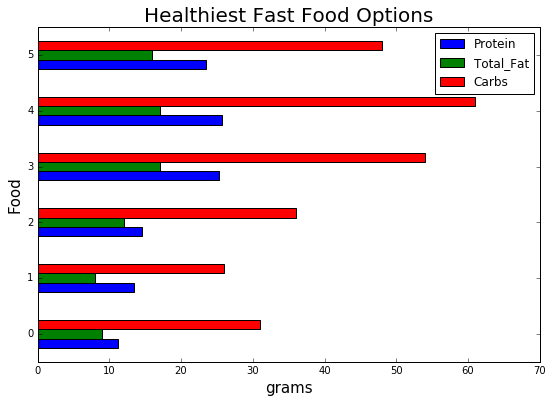

In [17]:
FoodResult = FoodResult.loc[:,['Protein','Total_Fat', 'Carbs']]
graph = FoodResult.plot(kind='barh', figsize=(9, 6), legend=True)
graph.set_xlabel('grams', size=15)
graph.set_ylabel('Food', size=15)
#graph.set_yticklabels(FoodResult['Resturant'], size=13)
graph.set_title('Healthiest Fast Food Options', size=20)

## Better Sides
Unfortunately, there is no such thing as healthy sides. French fries, onion rings and mozzerala sticks do not have good calories. They are high in fat and carbs with no little to no protien. What we did since people can't liv without them is give the top 5 lowest calorie sides in which can fill your desire for them.


In [18]:
Fries = Fries.sort(["Calories"], axis=0, ascending=True, inplace=False).head(5)
Fries

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
20,KFC,Potato Wedges,102,260,2.75,13,2.5,0,33,740,50.769231,45.000000,4.230769
16,Sonic,Regular,98,280,3.25,11,2.0,0,42,135,60.000000,35.357143,4.642857
22,Popeyes,Regular,88,310,4.25,17,7.0,1,35,660,45.161290,49.354839,5.483871
9,A&W,Chili,170,370,7.50,16,4.5,6,49,780,52.972973,38.918919,8.108108
17,Sonic,Cheese,125,380,8.25,19,7.0,0,44,600,46.315789,45.000000,8.684211


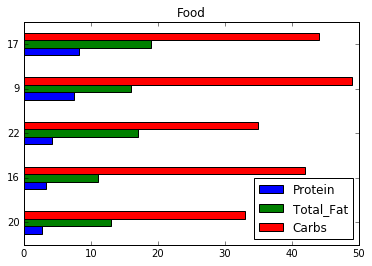

In [19]:
Fries = Fries.loc[:,['Protein','Total_Fat', 'Carbs']]
Fries.plot(kind='barh', title="Food")

## Top 5 Onion Rings with lowest calories

In [20]:
Onion_Rings = Onion_Rings.sort(["Calories"], axis=0, ascending=True, inplace=False).head(5)
Onion_Rings

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Restaurants,Serving_Size,Calories,Total_Fat,Protein,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
1,A&W,113,350,16,6.50,3.5,4.5,45,710,51.428571,41.142857,7.428571
3,White Castle (Sack),178,410,20,4.50,5.0,7.0,53,400,51.707317,43.902439,4.390244
7,Carl's Jr.,128,430,21,7.25,4.0,0.0,53,550,49.302326,43.953488,6.744186
0,Burger King (King Size),150,500,25,6.75,5.0,4.5,62,720,49.600000,45.000000,5.400000
2,Jack In The Box,119,500,30,6.50,6.0,10.0,51,420,40.800000,54.000000,5.200000


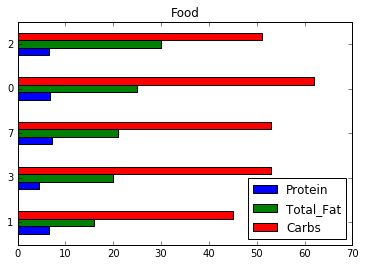

In [21]:
Onion_Rings = Onion_Rings.loc[:,['Protein','Total_Fat', 'Carbs']]
Onion_Rings.plot(kind='barh', title="Food")

## Top 5 Mozzarella Sticks with lowest calories

In [22]:
Mozzarella_Sticks = Mozzarella_Sticks.sort(["Calories"], axis=0, ascending=True, inplace=False).head(5)
Mozzarella_Sticks

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
2,Jack In The Box,3 pc,71.0,240,12.00,12,5,2.0,21,420,35.000000,45.000000,20.000000
4,White Castle,3 pc,79.2,250,9.00,14,6,2.0,22,750,35.200000,50.400000,14.400000
5,White Castle,5 pc,132.0,420,16.25,23,10,3.0,37,1240,35.238095,49.285714,15.476190
0,Arby's,4 pc (Regular),137.0,426,5.50,28,13,1.0,38,1370,35.680751,59.154930,5.164319
7,Sonic,0,140.0,440,20.50,22,9,0.5,40,1050,36.363636,45.000000,18.636364


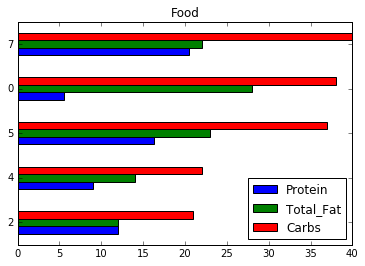

In [23]:
Mozzarella_Sticks = Mozzarella_Sticks.loc[:,['Protein','Total_Fat', 'Carbs']]
Mozzarella_Sticks.plot(kind='barh', title="Food")

# Top 5 Bread Stricks with lowest calories

In [24]:
BreadSticks_CheesyBread = BreadSticks_CheesyBread.sort(["Calories"], axis=0, ascending=True, inplace=False).head(5)
BreadSticks_CheesyBread

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
4,Little Caesars,Crazy Bread,1 pc,100,3.25,3,0.5,0,15,150,60.000000,27.000000,13.000000
2,Domino's Pizza,Breadsticks,1 pc,130,2.75,7,1.5,0,14,90,43.076923,48.461538,8.461538
5,Little Caesars,Italian Cheese Bread,1 pc,130,3.75,7,2.5,0,13,230,40.000000,48.461538,11.538462
3,Domino's Pizza,Cheesy Bread,1 pc,140,5.25,7,2.3,0,14,140,40.000000,45.000000,15.000000
7,Papa John's,Breadsticks,1 pc,140,4.50,2,0.0,0,26,260,74.285714,12.857143,12.857143


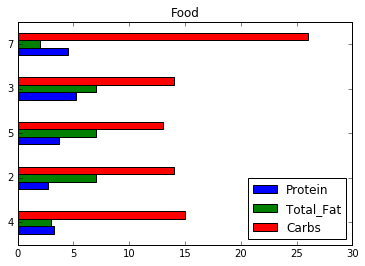

In [25]:
BreadSticks_CheesyBread = BreadSticks_CheesyBread.loc[:,['Protein','Total_Fat', 'Carbs']]
BreadSticks_CheesyBread.plot(kind='barh', title="Food")

In [26]:
#CREATE DB
con1 = lite.connect("Final_Project.db")

cur = con1.cursor()


#DROP TABLE IF EXISTS:
cur.execute("DROP TABLE IF EXISTS Fries")
cur.execute("DROP TABLE IF EXISTS Hamburgers")
cur.execute("DROP TABLE IF EXISTS Sandwiches_Hamburger")
cur.execute("DROP TABLE IF EXISTS Chicken_Pieces")
cur.execute("DROP TABLE IF EXISTS Chicken_Sandwiches")
cur.execute("DROP TABLE IF EXISTS Onion_Rings")
cur.execute("DROP TABLE IF EXISTS Bkfst_Sandwiches")
cur.execute("DROP TABLE IF EXISTS Mozzarella_Sticks")
cur.execute("DROP TABLE IF EXISTS BreadSticks_CheesyBread")
cur.execute("DROP TABLE IF EXISTS Pizza_Large14")


#Insert Into Database ALL OF DATAFRAMES

sql.write_frame(Fries, name='Fries', con=con1)
sql.write_frame(Hamburgers, name='Hamburgers', con=con1)
sql.write_frame(Sandwiches_Hamburger, name='Sandwiches_Hamburger', con=con1)
sql.write_frame(Chicken_Pieces, name='Chicken_Pieces', con=con1)
sql.write_frame(Chicken_Sandwiches, name='Chicken_Sandwiches', con=con1)
sql.write_frame(Onion_Rings, name='Onion_Rings', con=con1)
sql.write_frame(Bkfst_Sandwiches, name='Bkfst_Sandwiches', con=con1)
sql.write_frame(Mozzarella_Sticks, name='Mozzarella_Sticks', con=con1)
sql.write_frame(BreadSticks_CheesyBread, name='BreadSticks_CheesyBread', con=con1)
sql.write_frame(Pizza_Large14, name='Pizza_Large14', con=con1)

#Close Connection
con1.close()

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:22: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:24: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:26: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:27: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:28: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages

In [27]:
# TESTING DATABASE:
#CONNECTION:
con2 = lite.connect('Final_Project.db')
cur2 = con2.cursor()

#SQL COMMAND SELECTING TABLE
cur2.execute('SELECT * FROM Fries')

#FETCH ALL ROWS FROM TABLE
rows = cur2.fetchall()

#DISPLAY OF ROWS:
for row in rows:
    print (row, '    :Rows FROM|SQL TABLE')

#CLOSE SQL CONNECTION
con2.close()

(2.75, 13.0, 33.0)     :Rows FROM|SQL TABLE
(3.25, 11.0, 42.0)     :Rows FROM|SQL TABLE
(4.25, 17.0, 35.0)     :Rows FROM|SQL TABLE
(7.5, 16.0, 49.0)     :Rows FROM|SQL TABLE
(8.25, 19.0, 44.0)     :Rows FROM|SQL TABLE
